# PPO algorithm

In [20]:
import gym
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
from torch.autograd import Variable 

import numpy as np

import matplotlib.pyplot as plt
from myfunctions import space_size
space_size=space_size.space_size



env=gym.make('Pendulum-v0')
env.seed(0)

size=space_size(env)
a_s , o_s = size.a , size.o
D_in = size.o
D_out = size.a
ep_len, ep_max, e, gamma, batch_size= 200, 3000, 0.2, 0.9, 100
hypers = [ep_len, ep_max, e, gamma, batch_size] 
ε = [0.8, 0.1]
l_r = 1e-3

D_in, H, D_out = env.observation_space.shape[0], 100, env.action_space.shape[0]
N = 10 #epoch

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


# Neural network block

In [21]:
# Setting parameters for the activation function
action_range=np.array([env.action_space.low[0], env.action_space.high[0]],dtype=None)
[a,b]=[action_range.sum(), action_range.ptp()/2] # action [center, space]

# Actor Block
class actorNN(nn.Module):

    def __init__(self, D_in, H, D_out):
        super(actorNN, self).__init__()
        self.layerh = nn.Linear(D_in, H)
        self.mu_layer = nn.Linear(H, D_out)
        self.sigma_layer = nn.Linear(H, D_out)
        
    def forward(self, x):
        x = x.float() if type(x) == torch.Tensor else torch.from_numpy(x).float()
        h = self.layerh(x)
        h_relu = F.relu(h)
        mu = 2*torch.tanh(self.mu_layer(h))
        sigma = F.softplus(self.sigma_layer(h)) + 1e-3
        
        return mu, sigma

# Critic Block
class criticNN(nn.Module):
    
    def __init__(self, D_in, H, D_out):
        super(criticNN, self).__init__()
        self.layerh = nn.Linear(D_in, H)
        self.Vlayer = nn.Linear(H, D_out)
    
    def forward(self, x):
        x = x.float() if type(x) == torch.Tensor else torch.from_numpy(x).float()
        V_pred = self.Vlayer( F.relu( self.layerh(x) ) )
        return V_pred



# Agent block

In [ ]:
# Agent Block
class Agent():
    
    def __init__(self):
        self.gamma=gamma
        self.ep_len=ep_len
        

    def cum_reward(self, r_s):
        G=np.zeros_like(r_s)
        G[-1]=r_s[-1]
        for i in range(len(r_s)-2,-1,-1):
            G[i]=G[i+1]*gamma+r_s[i]
        return G
    
    def get_adv(self, r, v):
        
        A=np.zeros(self.ep_len)
        for i in range(self.ep_len-2):
            A[i] = r[i]- v[i] + gamma**(self.ep_len-i)*v[-1]
        #A= r + v[-2] - v[-1]
        return A
    
        """ def get_loss(self, A, r, e):
        # L_clip=E[min(r*A(t), np.clip(r, 1-self.e, 1+self.e))]
        # L_vf=E[Policy/Policy_old*A[t]-beta*]
        # S=
        #L_vf= 
        loss=[]#[L_clip, L_vf] # [L_clip,]
        return loss"""

# Update function

In [23]:

def update(s, a, r, s_n, a_lp, gamma, opta, optc):
    max_grad_norm = 0.5

    #s, a , r, s_n, a_lp = state_store, action_store, reward_store, state_store, action_lps
    s = torch.tensor(np.asarray(s[:-1:10]), dtype=torch.float)
    a = torch.tensor(np.asarray(a[:-1:10]), dtype=torch.float).view(-1, 1)
    r = torch.tensor(np.asarray(r[:-1:10]), dtype=torch.float).view(-1, 1)
    s_n = torch.tensor(np.asarray(s_n[1::10]), dtype=torch.float)
    old_action_log_probs = torch.tensor(a_lp[:-1:10], dtype=torch.float).view(-1, 1)
    
    r = (r - r.mean()) / (r.std() + 1e-5)
    with torch.no_grad():
        target_v = r + gamma * critic(s_n)

    adv = (target_v - critic(s)).detach()

    for _ in range(N):
        for index in BatchSampler( SubsetRandomSampler(range(ep_len//10)), 1, False):

            (mu, sigma) = actor.forward(s[index])
            dist = Normal(mu, sigma)
            action_log_probs = dist.log_prob(a[index])
            ratio = torch.exp(action_log_probs - old_action_log_probs[index])

            surr1 = ratio * adv[index]
            surr2 = torch.clamp(ratio, 1.0 - e,
                                1.0 + e) * adv[index]
            action_loss = -torch.min(surr1, surr2).mean()

            opta.zero_grad()
            action_loss.backward()
            nn.utils.clip_grad_norm_(actor.parameters(), max_grad_norm)
            opta.step()

            value_loss = F.smooth_l1_loss(critic(s[index]), target_v[index])
            optc.zero_grad()
            value_loss.backward()
            nn.utils.clip_grad_norm_(critic.parameters(), max_grad_norm)
            optc.step()

# main 

In [24]:

done = False
A=np.zeros(ep_max)

agent = Agent()
actor = actorNN(D_in, H, D_out)
critic = criticNN(D_in, H, D_out)

optim_a = optim.Adam(actor.parameters(), lr=1e-4)
optim_c = optim.Adam(critic.parameters(), lr=3e-4)


end_ep_reward=[]

for i_episodes in range(ep_max):
    
    state=env.reset()    
    state_store = []
    action_store = []
    reward_store = []
    v_store = []
    reward_sofar = 0
    action_lps = []
    
    for i_step in range(ep_len):
        # run actor and critic to get mean, std and Value function. 
        mu, sigma = actor.forward(state)
        v = critic.forward(state).item()
        
        # sampling the distribution to choose action:
        policy = Normal(mu[0],sigma[0])
        action = policy.sample()
        action_log_prob = policy.log_prob(action)
        action=action.item()
        
        # take action
        n_state, reward, done, _ = env.step([action])
        
        # storing
        state_store.append(state)
        action_store.append(action)
        action_lps.append(action_log_prob)
        reward_store.append(reward)
        v_store.append(v)
        
        # #calculate A, and L
        # A=agent.get_adv(reward_store, v)
        # L=Agent.get_loss(v, r, A, e)
        
        # update parameters
        state = n_state
        reward_sofar += reward
         
    end_ep_reward.append(reward_sofar)
    cum_reward = agent.cum_reward(reward_store)
    
    #calculate A, and L
    #A = agent.get_adv(cum_reward, v_store )
    #L = Agent.get_loss(v_store, reward_store, A, e)

    # update
    update(state_store, action_store, reward_store, state_store, action_lps, gamma, optim_a, optim_c)
    
    
    

# results

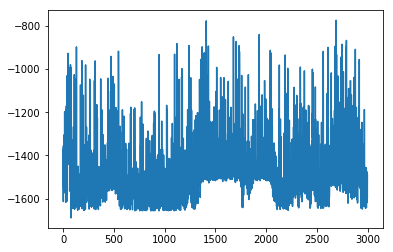

<function matplotlib.pyplot.show>

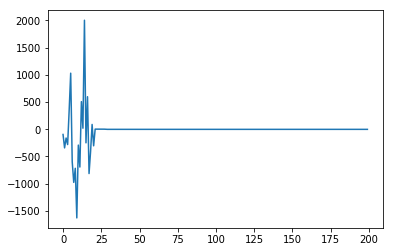

In [26]:
#plt.plot(reward_store)
plt.plot(end_ep_reward)
plt.show()

plt.plot(action_store)
plt.show